---
# Notebook 2: EDA and Cleaning
---
---
David Tersegno

4/1/22

This notebook opens the data gathered in Notebook 1.

The columns of the r/haskell data are examined, and one at a time, selected to be modified, kept, or removed. Two features are created from another related to the post's status as a crosspost to a submission in another subreddit. The same is done for the r/lua and r/lisp data. All three sets are saved in the folder `./data_clean`.

- [Import libraries](#Import-libraries)
- [Import data](#Import-data)
- [Define functions](#Define-functions)
    - [created_utc_to_datetime](#created_utc_to_datetime)
    - [get_timespan](#get_timespan)
    - [post_rate](#post_rate)
    - [plot_feature_with_time](#plot_feature_with_time)
    - [make_ones_column](#make_ones_column)
    - make_twenties_column
    - [format_md_table](#format_md_table)
    - [gather_crosspost_subreddits](#gather_crosspost_subreddits)
    - [unique_col_info](#unique_col_info)
    - [fill_in_the_blank](#fill_in_the_blank)
    - [drop_cols](#drop_cols)
- [Exploratory data analysis](#Exploratory-data-analysis)
    - [#r/haskell](#r/haskell)
    - [#r/lisp](#r/lisp)
    - [#r/lua](#r/lua)
    

## Import libraries

In [1]:
#import libraries
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# plt.style.use('dark_background')

## Import data

In [2]:
#import data from files
haskell_df = pd.read_csv('./data/haskell.csv', index_col = "Unnamed: 0")
haskell_c_df = pd.read_csv('./data/haskell_c.csv', index_col = "Unnamed: 0")
chaskell_df = haskell_c_df

lua_df = pd.read_csv('./data/lua.csv', index_col = "Unnamed: 0")
lua_c_df = pd.read_csv('./data/lua_c.csv', index_col = "Unnamed: 0")
clua_df = lua_c_df

lisp_df = pd.read_csv('./data/lisp.csv', index_col = "Unnamed: 0")
lisp_c_df = pd.read_csv('./data/lisp_c.csv', index_col = "Unnamed: 0")
clisp_df = lisp_c_df


#put the submission dataframes in a list for access later. Alphabetical order.
df_list = haskell_df, lisp_df, lua_df
#put the comments dataframes in a list for access later.
df_c_list = haskell_c_df, lisp_c_df, lua_c_df
#put all dataframes in a dictionary for explicitly looking at a certain subreddit
df_dict = {
    'haskell':{
        'posts':haskell_df,
        'comments':haskell_c_df
    },
    'lua':{
        'posts':lua_df,
        'comments':lua_c_df
    },
    'lisp':{
        'posts':lisp_df,
        'comments':lisp_c_df
    },
}

In [3]:
#Look at the first few entries in the haskell submissions DataFrame
haskell_df.head()

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,...,crosspost_parent_list,media,media_embed,secure_media,secure_media_embed,author_flair_background_color,author_flair_text_color,collections,author_cakeday,edited
0.0,[],False,yairchu,NaN,[],NaN,text,t2_33msg,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.0,[],False,flavortownXpress,NaN,[],NaN,text,t2_dxklpceb,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,[],False,emilypii,NaN,[],NaN,text,t2_rs0av,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,[],False,g_difolco,NaN,[],NaN,text,t2_735ekc4l,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,[],False,sridfr,NaN,[],NaN,text,t2_f1wkk8ou,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
---

# Define functions
---

This section defines some functions used later in this notebook.

## created_utc_to_datetime

Convert created_utc to a datetime

In [4]:
#create datetime columns from the 'created_utc' column.
def created_utc_to_datetime(df):
    return df['created_utc'].apply(lambda x: datetime.datetime.fromtimestamp(x))


for entry in df_dict:
    this_df = df_dict[entry]['posts']
    this_df['date'] = created_utc_to_datetime(this_df)
    this_df = df_dict[entry]['comments']
    this_df['date'] = created_utc_to_datetime(this_df)

## get_timespan
extract a DataFrame's time frame from either ```created_utc```  or `date` and return a timedelta

In [5]:
def get_timespan(df): #takes in a df and using its 'date' gives a timedelta
    return df['date'].max() - df['date'].min()
    
def get_timespan_utc(df): #takes in a df and using its 'created_utc' gives a timedelta
    end_time = datetime.datetime.fromtimestamp(df['created_utc'].max())
    start_time = datetime.datetime.fromtimestamp(df['created_utc'].min())
    return (end_time - start_time)
    
df_dict['haskell']['posts']['date'].max() - df_dict['haskell']['posts']['date'].min()

Timedelta('132 days 00:50:53')

### post_rate

Returns the average posting rate over the entire time range.

This rate is a bit less than the number of posts divided by time frame, it is
```
rate = (num_posts - 1)/time_length
```
This is so each post is assigned one length of time with no posts following.

In [6]:
#takes in a df, and returns the post rate per sec, day, hour, or week
def post_rate(df, unit = 'd'): #'s','d', 'h', 'w'
    num_posts = len(df)
    if unit == 's':
        sec_conversion = 1 # convert seconds to seconds. 1 sec == 1 sec.
    if unit == 'd':
        sec_conversion = 86400 #convert seconds to days
    elif unit == 'h':
        sec_conversion = 86400/24 #convert seconds to hours
    elif unit == 'w':
        sec_conversion = 86400*7 #convert seconds to weeks
    else:
        print(f'Pleace use unit = "s","h","d","w"')
        return None
    time_length = get_timespan(df).total_seconds()/sec_conversion
    return (num_posts - 1)/time_length  #cut off one boundary post


### plot_feature_with_time

A helper for plotting a feature with time.

In [7]:
#plots a feature from subreddit_df with posted date. returns the way
# plt.subplots() returns:  fig, ax

def plot_feature_with_time(df, feature='num_comments', second_df = [], second_df_feature = None, title='title', xlabel = None, ylabel = None, xlims = None, ylims = None, figuresize=(12,12)):
    feature_series = df[feature]
    date_series = df['date']
    fig, ax = plt.subplots(figsize = figuresize)
    ax.scatter(date_series, feature_series)
    if ylabel == None: 
        ax.set_ylabel(feature) #label y axis the feature name by default...
    else:
        ax.set_ylabel(ylabel) #...or give it a name
    if xlabel == None: 
        ax.set_xlabel('date')#label x axis 'date' by default...
    else:
        ax.set_xlabel(xlabel)# ...or give it a name
    ax.set_title(title) #set title
    if len(second_df) != 0:       #optionally plot a second series over this.
        if second_df_feature == None:
            second_df_feature = feature #plot the same feature as the main df by default
        second_date_series = second_df['date']
        second_feature_series = second_df[second_df_feature]
        ax.scatter(second_date_series, second_feature_series)
    return fig, ax
    

### make_ones_column

make a constant value column for comparing comments and submissions df plots by date.

In [8]:
#add a dummy column of all ones to a dataframe.
def make_ones_column(df):
    df_length = len(df)
    df['ones'] = pd.Series(np.full(df_length, 1))
    return df

def make_twenties_column(df):
    df_length = len(df)
    df['twenties'] = pd.Series(np.full(df_length, 20))
    return df

### Format MD Table

In [9]:
#list a few columns to put in a markdown table
table_these_cols = ['author', 'created_utc', 'date' ,'num_comments','num_crossposts', 'over_18', 'score', 'spoiler', 'pinned', 'stickied', 'is_gallery', 'gallery_data', 'crosspost_parent','media', 'media_embed','edited']

In [10]:
#create markdown table, send it to clipboard
pd.io.clipboards.to_clipboard(haskell_df[table_these_cols].head().to_markdown(), excel=False)

|    | author           |   created_utc | date                |   num_comments |   num_crossposts | over_18   |   score | spoiler   | pinned   | stickied   |   is_gallery |   gallery_data |   crosspost_parent |   media |   media_embed |   edited |
|---:|:-----------------|--------------:|:--------------------|---------------:|-----------------:|:----------|--------:|:----------|:---------|:-----------|-------------:|---------------:|-------------------:|--------:|--------------:|---------:|
|  0 | yairchu          |    1648561061 | 2022-03-29 09:37:41 |              0 |                0 | False     |       1 | False     | False    | False      |          nan |            nan |                nan |     nan |           nan |      nan |
|  1 | flavortownXpress |    1648557532 | 2022-03-29 08:38:52 |              0 |                0 | False     |       1 | False     | False    | False      |          nan |            nan |                nan |     nan |           nan |      nan |
|  2 | emilypii         |    1648508706 | 2022-03-28 19:05:06 |              0 |                0 | False     |       1 | False     | False    | False      |          nan |            nan |                nan |     nan |           nan |      nan |
|  3 | g_difolco        |    1648500965 | 2022-03-28 16:56:05 |              0 |                0 | False     |       1 | False     | False    | False      |          nan |            nan |                nan |     nan |           nan |      nan |
|  4 | sridfr           |    1648479814 | 2022-03-28 11:03:34 |              0 |                0 | False     |       1 | False     | False    | False      |          nan |            nan |                nan |     nan |           nan |      nan |

### format_md_table

I used info from [Joel McCune/](https://joelmccune.com/pandas-dataframe-to-markdown/) for help with the formatting.

In [11]:
#takes in a list of numbers or strings and spits out a markdown table. header optional.
def format_md_table(data_list:list, header:list = []) -> str:
    if header == []:
        header = '| --- '*len(data_list[0]) +'| \n'
    str_data_list = [
        ' | '.join([
            str(entry) for entry in row
        ])
        for row in data_list
    ]
    str_data_list.insert(header)
    return str_data_list
#     for row in data_list:
#         for entry in row:
#             result_str.append
    

### gather_crosspost_subreddits

Get all subreddits crossposted from a subreddit.

In [12]:
#takes a list of strings, and returns a list of subreddits following "\'subreddit'" in each string
def gather_crosspost_subreddit(crosspost):
    crosspost_tag = "\'subreddit\': " #search for this in the crosspost string.
    subreddit_char_start = crosspost.find(crosspost_tag) #gives the character index of the beginning of this.
#     subreddit_char_start += len(crosspost_tag)
    subreddit_char_start += crosspost[subreddit_char_start:].find(": '") + len(": '")
    subreddit_char_end = subreddit_char_start + crosspost[subreddit_char_start:].find("'")
    subreddit_string = crosspost[subreddit_char_start:subreddit_char_end]
    return subreddit_string

In [13]:
#test it out.
crossposts = haskell_df['crosspost_parent_list'].dropna()

gather_crosspost_subreddit(crossposts[crossposts.index[20]])

'opensource'

In [14]:
#test it out again.
gather_crosspost_subreddit(crossposts[crossposts.index[10]])

'learnprogramming'

### unique_col_info

Combines some of the information in `df.value_counts()` and `df.info()`

In [15]:
# takes in a df, and two indices for the columns list. returns info about uniques and nonnulls 
def unique_col_info(df, colindex1, colindex2):
    new_df = df[df.columns[colindex1:colindex2]].apply(lambda series: (len(series.unique()), len(series.dropna()), series.value_counts().max(), series.unique())).T
    new_df.columns = ['len(uniques)', 'value_counts max', 'non-nulls', 'uniques']
    return new_df

### fill_in_the_blank
Lets you pick which columns to apply `df.fillna()` to.

In [16]:
# fill selftext NaNs with blank strings, edits inplace and returns the original df.
def fill_in_the_blank(df, columns:list, fill_val = ''):
    for column in columns:
        df[column].fillna(fill_val, inplace = True)
    return df

## drop_cols

These are the columns to be dropped from the data. Also included is `string_cols_with_NaNs`,`numerical_cols_with_NaNs`,`dummify_these_columns`, `dummy_columns_to_drop`, which all collect column names. Different operations will transform the columns if their name is present in these lists.

The values are selected by analysis further in this document. They are defined here so they may be used by `full_data_process`, defined ahead.

In [17]:
drop_cols = ['all_awardings',
 'allow_live_comments',
 'author',
 'author_flair_background_color',
  'author_flair_richtext',
  'author_premium',
  'author_flair_css_class',
  'author_flair_text',
  'author_flair_type',
 'author_fullname',
 'author_is_blocked',
 'author_patreon_flair',
 'awarders',
 'can_mod_post',
 'contest_mode',
 'crosspost_parent',
 'full_link',
 'gildings',
 'is_created_from_ads_ui',
 'is_meta',
 'is_video',
 'num_crossposts',
  'over_18',
  'parent_whitelist_status',
  'permalink',
  'pinned',
 'pwls', 
'retrieved_on',
'send_replies',
'spoiler',
'stickied',
 'subreddit_id',
  'subreddit_subscribers',
  'subreddit_type',
  'total_awards_received',
  'treatment_tags',
  'url',
  'whitelist_status',
 'wls',
  'link_flair_template_id',
  'url_overridden_by_dest',
  'media_metadata',
  'gallery_data',
  'is_gallery',
 'media_embed',
  'secure_media',
  'secure_media_embed',
  'author_flair_background_color',
  'author_flair_text_color',
  'collections',
  'author_cakeday',
 'edited',
'link_flair_background_color',    
 'link_flair_richtext',       
 'link_flair_text',
    'link_flair_text_color',
     'link_flair_type',
    'media',
    'media_only',
    'no_follow',
      'preview',
     'removed_by_category',
       'locked']

string_cols_with_NaNs =  ['crosspost_parent_list',
                          'selftext',
                          'post_hint']

numerical_cols_with_NaNs = ['thumbnail_height',
                           'thumbnail_width']



# assign dummy columns by name
dummify_these_columns = ['domain', 'thumbnail', 'crosspost_subreddit', 'post_hint']


dummy_columns_to_drop = ['post_hint_', 
 'crosspost_subreddit_', ]

In [18]:
(set(drop_cols)-set(['collections']))

{'all_awardings',
 'allow_live_comments',
 'author',
 'author_cakeday',
 'author_flair_background_color',
 'author_flair_css_class',
 'author_flair_richtext',
 'author_flair_text',
 'author_flair_text_color',
 'author_flair_type',
 'author_fullname',
 'author_is_blocked',
 'author_patreon_flair',
 'author_premium',
 'awarders',
 'can_mod_post',
 'contest_mode',
 'crosspost_parent',
 'edited',
 'full_link',
 'gallery_data',
 'gildings',
 'is_created_from_ads_ui',
 'is_gallery',
 'is_meta',
 'is_video',
 'link_flair_background_color',
 'link_flair_richtext',
 'link_flair_template_id',
 'link_flair_text',
 'link_flair_text_color',
 'link_flair_type',
 'locked',
 'media',
 'media_embed',
 'media_metadata',
 'media_only',
 'no_follow',
 'num_crossposts',
 'over_18',
 'parent_whitelist_status',
 'permalink',
 'pinned',
 'preview',
 'pwls',
 'removed_by_category',
 'retrieved_on',
 'secure_media',
 'secure_media_embed',
 'send_replies',
 'spoiler',
 'stickied',
 'subreddit_id',
 'subreddit_su

## full_data_process

This procedure will transform the imported data to a form ready for exporting. The applied operations are determined further ahead in this notebook.

In [19]:
# takes in a DataFrame, returns a DataFrame.

def full_data_process(df):
    #drop uninteresting columns
    if 'collections' in df.columns:
        df_dropped = pd.DataFrame(df.drop(columns=drop_cols)) #making sure it's a copy
    else:
        df_dropped = pd.DataFrame(df.drop(columns=(set(drop_cols)-set(['collections']))))
    
    #fill crosspost_parent_list NaN with blank strings
    df_dropped['crosspost_parent_list'].fillna('', inplace=True)
    
    #fill post_hint NaNs with blank strings
    df_dropped['post_hint'].fillna('', inplace = True)
    
    #fill in all remaining object columns with NaNs with empty strings
    fill_in_the_blank(df_dropped, string_cols_with_NaNs)
    
    # fill in all remaining numerical columns with 0s.
    fill_in_the_blank(df_dropped, numerical_cols_with_NaNs, fill_val=0)
    
    #make a new column that says if a post is a crosspost, based on having the data for its parent or not.
    df_dropped['is_crosspost'] = df_dropped['crosspost_parent_list'].apply(lambda x: 0 if x == '' else 1)
    
    #make a new column with just the subreddit of the parent post.
    df_dropped['crosspost_subreddit'] = df_dropped['crosspost_parent_list'].apply(lambda x: x if x == '' else gather_crosspost_subreddit(x))
    #drop crosspostparentlist now that the crosspost parent subreddit has been extracted, and...
    #drop id. reintrodce it if you're working with comments.
    df_dropped.drop(columns=['crosspost_parent_list','id'], inplace=True)
    
    #make and look at created columns
    df_dum = pd.get_dummies(df_dropped, columns=dummify_these_columns)
    
    #drop columns that imply a missing value
    df_dum.drop(columns = dummy_columns_to_drop, inplace=True)
    
    return df_dum

In [20]:
#see how it works.
full_data_process(haskell_df)

,created_utc,is_crosspostable,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,num_comments,score,selftext,subreddit,...,crosspost_subreddit_programming,crosspost_subreddit_rust,crosspost_subreddit_selfhosted,crosspost_subreddit_termux,crosspost_subreddit_vscode,post_hint_hosted:video,post_hint_image,post_hint_link,post_hint_rich:video,post_hint_self
0.0,1648561061,True,False,False,True,True,0,1,Being that native ARM executables should perfo...,haskell,...,0,0,0,0,0,0,0,0,0,1
1.0,1648557532,True,False,False,True,True,0,1,Anything I cabal install is unavailable in my ...,haskell,...,0,0,0,0,0,0,0,0,0,0
2.0,1648508706,True,False,False,True,True,0,1,"Hello All,\n\nI'm pleased to announce that `ba...",haskell,...,0,0,0,0,0,0,0,0,0,0
3.0,1648500965,True,False,False,True,True,0,1,As the new maintainer of [bloodhound](https://...,haskell,...,0,0,0,0,0,0,0,0,0,0
4.0,1648479814,True,False,False,True,False,0,1,,haskell,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995.0,1637235748,True,False,False,True,False,13,1,,haskell,...,0,0,0,0,0,0,0,1,0,0
996.0,1637192872,False,False,False,False,False,0,1,,haskell,...,0,0,0,0,0,0,0,0,1,0
997.0,1637182153,True,True,False,True,False,6,1,,haskell,...,0,0,0,0,0,0,0,0,0,0
998.0,1637172516,True,False,False,True,True,6,1,divisors : : Int -&gt; [Int]\ndivisors 0 = [0]...,haskell,...,0,0,0,0,0,0,0,0,0,0


---
# Exploratory data analysis

Perform EDA on the r/haskell data.

Restructure the features alphabetically.

In [21]:
haskell_df = haskell_df.sort_index(axis = 1)

### r/haskell

In [22]:
#assign a label for plots and tables
this_subreddit = 'r/haskell'

# look at dataframe size, column names, non-missing value count, data types.
haskell_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1000 entries, 0.0 to 999.0
Data columns (total 82 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   all_awardings                  1000 non-null   object        
 1   allow_live_comments            1000 non-null   bool          
 2   author                         1000 non-null   object        
 3   author_cakeday                 3 non-null      object        
 4   author_flair_background_color  0 non-null      float64       
 5   author_flair_css_class         0 non-null      float64       
 6   author_flair_richtext          995 non-null    object        
 7   author_flair_text              1 non-null      object        
 8   author_flair_text_color        6 non-null      object        
 9   author_flair_type              995 non-null    object        
 10  author_fullname                995 non-null    object        
 11  author_is_bl

In [23]:
# look at first few observations in the dataframe.
haskell_df.head()

,all_awardings,allow_live_comments,author,author_cakeday,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_text_color,author_flair_type,...,thumbnail_height,thumbnail_width,title,total_awards_received,treatment_tags,upvote_ratio,url,url_overridden_by_dest,whitelist_status,wls
0.0,[],False,yairchu,NaN,NaN,NaN,[],NaN,NaN,text,...,NaN,NaN,"Now that Stackage supports GHC 9.2, is it easy...",0,[],1.0,https://www.reddit.com/r/haskell/comments/tqzx...,NaN,all_ads,6
1.0,[],False,flavortownXpress,NaN,NaN,NaN,[],NaN,NaN,text,...,NaN,NaN,when I cabal install anything why is it access...,0,[],1.0,https://www.reddit.com/r/haskell/comments/tqyt...,NaN,all_ads,6
2.0,[],False,emilypii,NaN,NaN,NaN,[],NaN,NaN,text,...,NaN,NaN,"[ANN] base16-0.3.2.0, base32-0.2.2.0, base64-0...",0,[],1.0,https://www.reddit.com/r/haskell/comments/tqlt...,NaN,all_ads,6
3.0,[],False,g_difolco,NaN,NaN,NaN,[],NaN,NaN,text,...,NaN,NaN,[ANN] bloodhound-0.19.0.0,0,[],1.0,https://www.reddit.com/r/haskell/comments/tqj5...,NaN,all_ads,6
4.0,[],False,sridfr,NaN,NaN,NaN,[],NaN,NaN,text,...,NaN,NaN,More thoughts on the Expression Problem in Has...,0,[],1.0,https://eli.thegreenplace.net/2018/more-though...,https://eli.thegreenplace.net/2018/more-though...,all_ads,6


In [24]:
# look at summary statistics for numerical values.
haskell_df.describe()

,author_flair_background_color,author_flair_css_class,created_utc,edited,num_comments,num_crossposts,pwls,retrieved_on,score,subreddit_subscribers,thumbnail_height,thumbnail_width,total_awards_received,upvote_ratio,wls
count,0.0,0.0,1.000000e+03,2.000000e+00,1000.000000,1000.0,1000.0,1.000000e+03,1000.000000,1000.000000,194.000000,194.000000,1000.0,1000.000000,1000.0
mean,NaN,NaN,1.642492e+09,1.638967e+09,3.258000,0.0,6.0,1.642494e+09,1.184000,68518.808000,103.159794,138.453608,0.0,0.997710,6.0
std,NaN,NaN,3.306919e+06,5.544778e+04,9.911492,0.0,0.0,3.305729e+06,2.199314,677.759563,31.432801,10.757834,0.0,0.027368,0.0
min,NaN,NaN,1.637157e+09,1.638928e+09,0.000000,0.0,6.0,1.637157e+09,0.000000,67275.000000,31.000000,50.000000,0.0,0.500000,6.0
25%,NaN,NaN,1.639542e+09,1.638948e+09,0.000000,0.0,6.0,1.639542e+09,1.000000,67946.250000,70.000000,140.000000,0.0,1.000000,6.0
50%,NaN,NaN,1.642301e+09,1.638967e+09,0.000000,0.0,6.0,1.642301e+09,1.000000,68570.000000,105.000000,140.000000,0.0,1.000000,6.0
75%,NaN,NaN,1.645215e+09,1.638987e+09,0.000000,0.0,6.0,1.645215e+09,1.000000,69120.000000,140.000000,140.000000,0.0,1.000000,6.0
max,NaN,NaN,1.648561e+09,1.639006e+09,126.000000,0.0,6.0,1.648561e+09,47.000000,69579.000000,140.000000,140.000000,0.0,1.000000,6.0


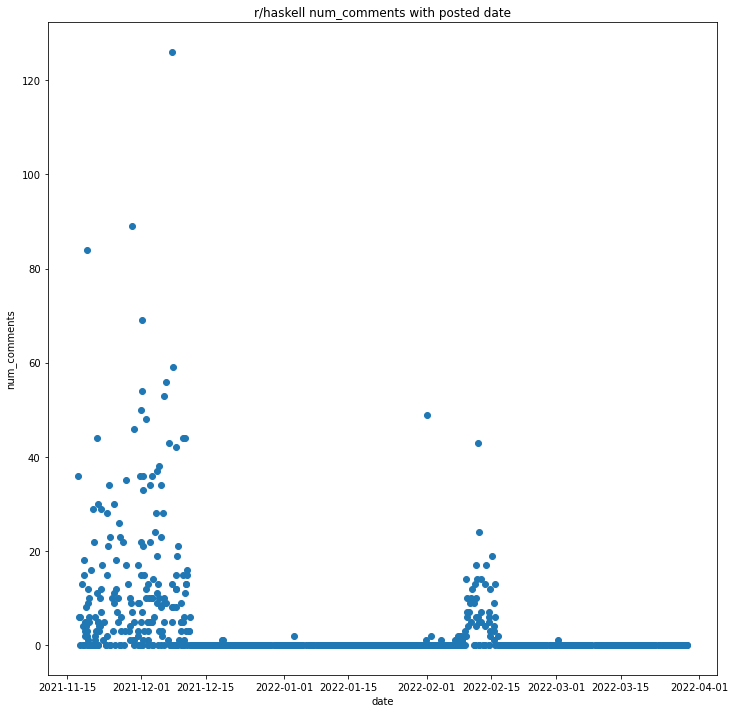

In [25]:
### look at posts and comments with time.
plot_feature_with_time(haskell_df, title=f'{this_subreddit} num_comments with posted date');

There appear to be very few comments for posts from Dec '21 through January '22, and another lull beginning after. These are due to a widespread server outage:

    Watchful1
    ·
    There's currently an outage with the api servers. If you do

    https://api.pushshift.io/reddit/comment/search/?q=test&metadata=true&limit=0

    it says "shards successful: 67", "shards total: 74". So there's some shards that are down and the api is returning incomplete results. It was worse yesterday, but some shards were replaced. Redoing your collection now should have better results, and hopefully the remaining shards will be recovered soon.

[Reddit](https://www.reddit.com/r/pushshift/comments/rfg8b1/lack_of_submissions_in_2020_and_2021/)

[AP News: EXPLAINER: What caused Amazon’s outage? Will there be more?](https://apnews.com/article/technology-business-amazoncom-inc-cloud-computing-bdac5ca23b28ef9c48f6851956e80716)

This portion of the data is missing. Using comments for the model may not be a good idea.

### Post rate
Get the average post rates for the submissions.

In [26]:
#average posting rate per day
post_rate(haskell_df)

7.566156401208888

In [27]:
#average comment rate per day
post_rate(haskell_c_df)

60.680854234933584

### Looking at columns one at a time.

Drop columns with little or no data. The names will be kept in a list, and then dropped afterwards. Keep track of columns with NaNs and other concerning features.

In [28]:
drop_cols = [] #keep track of features to drop.
nan_cols = [] #wkeep track of features with NaNs that need to be dealt with.
unsure_cols = [] #I'll return to some at the end. 

In [29]:
#look at info that could inform which columns to drop.

#look at the first ten columns
unique_col_info(haskell_df, 0,10)

,len(uniques),value_counts max,non-nulls,uniques
all_awardings,1,1000,1000,[[]]
allow_live_comments,2,1000,998,"[False, True]"
author,603,1000,30,"[yairchu, flavortownXpress, emilypii, g_difolc..."
author_cakeday,2,3,3,"[nan, True]"
author_flair_background_color,1,0,NaN,[nan]
author_flair_css_class,1,0,NaN,[nan]
author_flair_richtext,2,995,995,"[[], nan]"
author_flair_text,2,1,1,"[nan, css wrangler]"
author_flair_text_color,2,6,6,"[nan, dark]"
author_flair_type,2,995,995,"[text, nan]"


In [30]:
# drop all awardings feature. The entire list is empty.

drop_cols.append('all_awardings')
haskell_df['all_awardings'].value_counts()

[]    1000
Name: all_awardings, dtype: int64

In [31]:
#drop live comments, bool. Two are True. Not enough to work with.

drop_cols.append('allow_live_comments')
haskell_df['allow_live_comments'].sum()

2

In [32]:
#drop authors. Too closely attached to subreddit for this kind of problem.

drop_cols.append('author')
haskell_df['author']

0.0                  yairchu
1.0         flavortownXpress
2.0                 emilypii
3.0                g_difolco
4.0                   sridfr
                ...         
995.0              peargreen
996.0               ysangkok
997.0            techmindful
998.0           touchmelenny
999.0    have-ahappygenocide
Name: author, Length: 1000, dtype: object

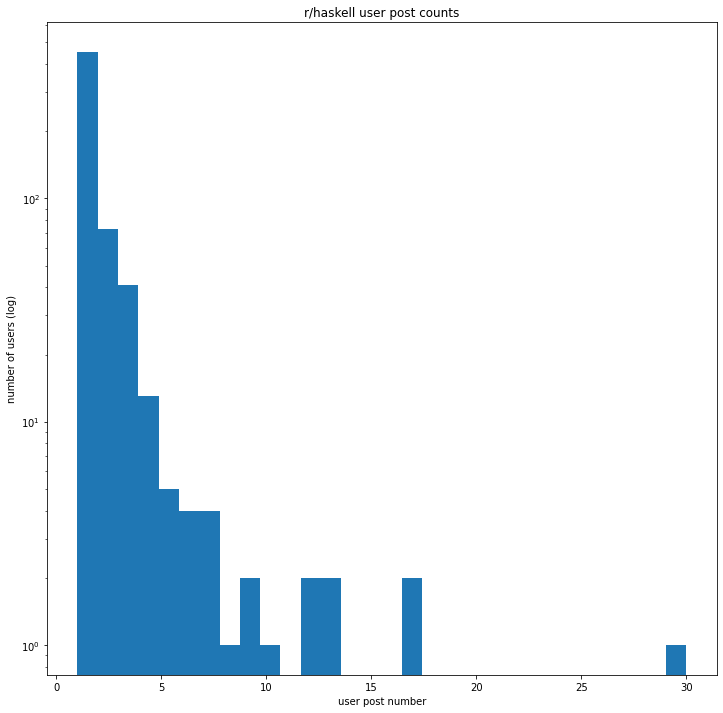

In [33]:
#Out of curiousity, take a look at the post counts per author.

#make a histogram of post counts per author.
vcs = haskell_df['author'].value_counts()
plt.figure(figsize=(12,12))
plt.title(f'{this_subreddit} user post counts')
plt.xlabel(f'user post number')
plt.ylabel('number of users (log)')
plt.hist(vcs, bins = 30, log = True);

In [34]:
#continue deciding on features to trash or keep...
unique_col_info(haskell_df, 10,20)

,len(uniques),value_counts max,non-nulls,uniques
author_fullname,603,995,30,"[t2_33msg, t2_dxklpceb, t2_rs0av, t2_735ekc4l,..."
author_is_blocked,1,1000,1000,[False]
author_patreon_flair,2,995,995,"[False, nan]"
author_premium,3,995,986,"[False, True, nan]"
awarders,1,1000,1000,[[]]
can_mod_post,1,1000,1000,[False]
collections,27,30,2,"[nan, [{'author_id': 't2_4hurx', 'author_name'..."
contest_mode,1,1000,1000,[False]
created_utc,1000,1000,1,"[1648561061, 1648557532, 1648508706, 164850096..."
crosspost_parent,21,21,2,"[nan, t3_tezoil, t3_tdyf78, t3_tcnns1, t3_t9dn..."


In [35]:
#looking at more features...
unique_col_info(haskell_df, 20,30)

,len(uniques),value_counts max,non-nulls,uniques
crosspost_parent_list,22,21,1,"[nan, [{'all_awardings': [], 'allow_live_comme..."
date,1000,1000,1,"[2022-03-29T09:37:41.000000000, 2022-03-29T08:..."
domain,124,1000,714,"[self.haskell, eli.thegreenplace.net, github.c..."
edited,3,2,1,"[nan, 1639006483.0, 1638928068.0]"
full_link,1000,1000,1,[https://www.reddit.com/r/haskell/comments/tqz...
gallery_data,3,2,1,"[nan, {'items': [{'id': 124221337, 'media_id':..."
gildings,1,1000,1000,[{}]
id,1000,1000,1,"[tqzxy1, tqytst, tqltwe, tqj5ki, tqbba5, tq6my..."
is_created_from_ads_ui,1,1000,1000,[False]
is_crosspostable,2,1000,881,"[True, False]"


In [36]:
# Any column will all the same value should be dropped.
haskell_df['author_flair_css_class'].isnull().sum()

1000

In [37]:
haskell_df['author_flair_richtext'].unique()

array(['[]', nan], dtype=object)

In [38]:
haskell_df['author_flair_text'].unique()

array([nan, 'css wrangler'], dtype=object)

In [39]:
haskell_df['author_flair_type'].unique()

array(['text', nan], dtype=object)

In [40]:
#drop these columns.
drop_cols.append(['author_flair_background_color',	'author_flair_richtext','author_premium','author_flair_css_class','author_flair_text','author_flair_type'])

In [41]:


# drop. it appears this feature is an alternative to author.
# it is worth noting that author codes appear to start with t2_.
# submission codes are t3_, as will be seen ahead.
# comment codes are t1_
drop_cols.append('author_fullname')
haskell_df['author_fullname'].head()

0.0       t2_33msg
1.0    t2_dxklpceb
2.0       t2_rs0av
3.0    t2_735ekc4l
4.0    t2_f1wkk8ou
Name: author_fullname, dtype: object

In [42]:
#drop 'author_is_blocked'
drop_cols.append('author_is_blocked')

# nobody's blocked.
haskell_df['author_is_blocked'].sum()

0

In [43]:
# drop 'author_patreon_flair'
drop_cols.append('author_patreon_flair')

# nothing useful here.
haskell_df['author_patreon_flair'].value_counts()

False    995
Name: author_patreon_flair, dtype: int64

In [44]:
# keep 'author_premium'

# I want to look at this more. Do premium authorstend to have status in the community?
# are they treated differently between subreddits?
haskell_df['author_premium'].sum()

9

In [45]:
# drop 'awarders'
drop_cols.append('awarders')

haskell_df['awarders'].value_counts()

[]    1000
Name: awarders, dtype: int64

In [46]:
#drop 'can_mod_post'
drop_cols.append('can_mod_post')

haskell_df['can_mod_post'].sum()

0

In [47]:
# drop 'contest_mode'
drop_cols.append('contest_mode')

haskell_df['contest_mode'].sum()

0

In [48]:
# keep created_utc.
# created_utc is the epoch time of the post.
# none are null. This is A-OK. Add to neither drop_cols nor nan_cols.


# it will not be used in the model, but it is useful for plotting.
haskell_df['created_utc'].isnull().sum()

0

Crossposts --- Reddit allows a way to copy and create a new instance of a post in a different subreddit that is distinct from a link, according to this [Online Tech Tips](https://www.online-tech-tips.com/computer-tips/how-to-crosspost-on-reddit/) article. This new instance tracks its own comments from then on, independent of the original from which it was copied.

In [49]:
# crosspost_parent.
# this is an identifier for finding the post in another subreddit
haskell_df['crosspost_parent'].value_counts()

t3_rqn0aj    2
t3_tezoil    1
t3_tdyf78    1
t3_rcjzpo    1
t3_re0bal    1
t3_qttgej    1
t3_rn6omd    1
t3_rt1jz0    1
t3_rtkmvt    1
t3_s2hil6    1
t3_sgvk35    1
t3_sh9uif    1
t3_sh947t    1
t3_skwlvb    1
t3_snx262    1
t3_sreldj    1
t3_t1xf0g    1
t3_t9dnfb    1
t3_tcnns1    1
t3_rc0x8m    1
Name: crosspost_parent, dtype: int64

In [50]:
# none of the crosspost parents are in the ids
haskell_df['crosspost_parent'].apply(lambda x: True if x in list(haskell_df['id']) else False).sum()

0

In [51]:
# none of the crosspost parents are in the comment parent ids
haskell_df['crosspost_parent'].apply(lambda x: True if x in list(haskell_c_df['parent_id']) else False).sum()

0

In [52]:
# drop 'crosspost_parent'. It only refers to post IDs in other subreddits. We probably don't
# have data for, unless these ones happen to crosspost between each other primarily. This
# problem would be pretty tough, if so.

drop_cols.append('crosspost_parent')

In [53]:
# look at 'crosspost_parent_list'
list(haskell_df['crosspost_parent_list'].dropna())[0]

'[{\'all_awardings\': [], \'allow_live_comments\': False, \'approved_at_utc\': None, \'approved_by\': None, \'archived\': False, \'author\': \'pm_me_r34_r34\', \'author_flair_background_color\': None, \'author_flair_css_class\': None, \'author_flair_richtext\': [], \'author_flair_template_id\': None, \'author_flair_text\': None, \'author_flair_text_color\': None, \'author_flair_type\': \'text\', \'author_fullname\': \'t2_vdd44hm\', \'author_is_blocked\': False, \'author_patreon_flair\': False, \'author_premium\': False, \'awarders\': [], \'banned_at_utc\': None, \'banned_by\': None, \'can_gild\': True, \'can_mod_post\': False, \'category\': None, \'clicked\': False, \'content_categories\': None, \'contest_mode\': False, \'created\': 1647376576.0, \'created_utc\': 1647376576.0, \'discussion_type\': None, \'distinguished\': None, \'domain\': \'self.rust\', \'downs\': 0, \'edited\': False, \'gilded\': 0, \'gildings\': {}, \'hidden\': False, \'hide_score\': True, \'id\': \'tezoil\', \'is_c

This is an observation for a post in another subreddit! This will be extremely useful. I
will make an `is_crosspost feature` later ahead, and extract at least the subreddit of the original
post as `crosspost_subreddit`. Maybe there's a set of likely-linked-to-subreddits among r/haskell.

In [54]:
# keep 'date' for the same reason as 'created_utc'.

In [55]:
# keep 'domain'. It appears to be the page a post links to.

haskell_df['domain'].unique()

array(['self.haskell', 'eli.thegreenplace.net', 'github.com',
       'haskell.foundation', 'haskellweekly.news', 'reddit.com',
       'twitter.com', 'well-typed.com', 'dmitrytsepelev.dev',
       'serokell.io', 'leanprover.github.io', 'lambda.cicada-lang.org',
       'stackage.org', 'discourse.haskell.org', 'prophetlabs.de',
       'arfasoftech.com', 'self.rust', 'self.PHP',
       '/r/haskell/comments/telf9t/haskellers_functional_conf_2022_is_online_and/',
       'imgur.com', 'hackage.haskell.org', 'youtube.com', 'coot.me',
       'leanpub.com', 'luctielen.com', 'blog.functorial.com',
       'redbubble.com', 'blog.devgenius.io', 'elbear.com', 'haskell.org',
       'haskellforall.com', 'chester-beard.medium.com', 'anchor.fm',
       'i.redd.it', 'surveyhero.com', 'jappie.me', 'stefan-klinger.de',
       'techcrunch.com', 'i-programmer.info', 'dfithian.github.io',
       'tweag.io', 'gitlab.haskell.org', 'typeable.io',
       'thecodedmessage.com', 'zfoh.ch', 'divip.hu', 'fosskers.ca',


In [56]:
# keep 'edited' for now. I suspect this is an epoch time. There are only a couple entires, but maybe 
# one of the other subreddits has a lot of them.
haskell_df['edited'].unique()

array([           nan, 1.63900648e+09, 1.63892807e+09])

In [57]:
# drop full link. We already have all the info in the links.

drop_cols.append('full_link')
haskell_df['full_link']

0.0      https://www.reddit.com/r/haskell/comments/tqzx...
1.0      https://www.reddit.com/r/haskell/comments/tqyt...
2.0      https://www.reddit.com/r/haskell/comments/tqlt...
3.0      https://www.reddit.com/r/haskell/comments/tqj5...
4.0      https://www.reddit.com/r/haskell/comments/tqbb...
                               ...                        
995.0    https://www.reddit.com/r/haskell/comments/qwny...
996.0    https://www.reddit.com/r/haskell/comments/qwca...
997.0    https://www.reddit.com/r/haskell/comments/qw8m...
998.0    https://www.reddit.com/r/haskell/comments/qw57...
999.0    https://www.reddit.com/r/haskell/comments/qvzm...
Name: full_link, Length: 1000, dtype: object

In [58]:
# unsure of 'gallery_data'. there is info here, looks like comments on a piece of media.

unsure_cols.append('gallery_data')
haskell_df['gallery_data'].unique()

array([nan,
       '{\'items\': [{\'id\': 124221337, \'media_id\': \'go9yr6hwrfp81\'}, {\'id\': 124221338, \'media_id\': \'w4m5b5hwrfp81\'}, {\'caption\': "I cannot understand how to do the numPizza function. I\'ve made a start on it, and tried to make helper functions but im quite unsure how to proceed. VERY new to haskell. ", \'id\': 124221339, \'media_id\': \'ey9bjyhwrfp81\'}]}',
       "{'items': [{'id': 102036619, 'media_id': 'ejkaq8clzib81'}, {'id': 102036620, 'media_id': 'g3tlkmfmzib81'}]}"],
      dtype=object)

In [59]:
# drop 'gildings'. it's all empty dicts

drop_cols.append('gildings')
haskell_df['gildings'].unique()

array(['{}'], dtype=object)

In [60]:
# keep 'id' for now. it's needed to check for links and comment ownership.

haskell_df['id']

0.0      tqzxy1
1.0      tqytst
2.0      tqltwe
3.0      tqj5ki
4.0      tqbba5
          ...  
995.0    qwnyfa
996.0    qwcami
997.0    qw8mw1
998.0    qw5775
999.0    qvzms9
Name: id, Length: 1000, dtype: object

In [61]:
# Drop 'is_created_from_ads_ui' --- all false

drop_cols.append('is_created_from_ads_ui')
haskell_df['is_created_from_ads_ui'].sum()

0

In [62]:
# keep 'is_crosspostable.' There seem to be more than a couple that aren't.
haskell_df['is_crosspostable'].sum()

881

In [63]:
#wait to see about 'is_gallery'. 

unsure_cols.append('is_gallery')

haskell_df['is_gallery'].sum()

2

In [64]:
# drop 'is_meta'.

drop_cols.append('is_meta')
haskell_df['is_meta'].sum()

0

In [65]:
#Keep 'is_original_content'.

haskell_df['is_original_content'].sum()

20

In [66]:
#keep 'is_reddit_media_domain'

haskell_df['is_reddit_media_domain'].sum()

11

In [67]:
#keep is robot indexable
haskell_df['is_robot_indexable'].sum()

881

In [68]:
#keep is_self.
haskell_df['is_self'].sum()

714

In [69]:
#drop is_video

drop_cols.append('is_video')
haskell_df['is_video'].sum()

2

In [70]:
# drop 'link_flair_background_color'
haskell_df['link_flair_background_color'].unique()

array([nan, '#646d73'], dtype=object)

In [71]:
#look at the next 10 columns.
haskell_df[haskell_df.columns[30:40]].apply(lambda series: (len(series.unique()), len(series.dropna()), series.unique())).T

,0,1,2
is_gallery,2,2,"[nan, True]"
is_meta,1,1000,[False]
is_original_content,2,1000,"[False, True]"
is_reddit_media_domain,2,1000,"[False, True]"
is_robot_indexable,2,1000,"[True, False]"
is_self,2,1000,"[True, False]"
is_video,2,1000,"[False, True]"
link_flair_background_color,2,337,"[nan, #646d73]"
link_flair_richtext,1,1000,[[]]
link_flair_template_id,13,337,"[nan, fd84a740-e679-11e8-ae50-0eda5d02591a, b4..."


In [72]:
# keep no follow.
haskell_df['no_follow'].sum()

876

In [73]:
# keep num_comments.
#drop permalink.
# drop num_crossposts
#drop over18
#drop parent_whitelist_status

#drop pinned. it is too rare, just knowing how reddit works.
drop_cols.append([ 'num_crossposts', 'over_18', 'parent_whitelist_status', 'permalink', 'pinned'])


In [74]:
#look at the next 10 columns.
unique_col_info(haskell_df, 40, 50)

,len(uniques),value_counts max,non-nulls,uniques
link_flair_text,14,339,159,"[nan, announcement, blog, question, homework, ..."
link_flair_text_color,2,1000,663,"[dark, light]"
link_flair_type,1,1000,1000,[text]
locked,1,1000,1000,[False]
media,28,27,1,"[nan, {'oembed': {'description': 'Post with 0 ..."
media_embed,28,27,1,"[nan, {'content': '&lt;iframe class=""embedly-e..."
media_metadata,12,11,1,"[nan, {'4647prsa8ip81': {'e': 'Image', 'id': '..."
media_only,1,1000,1000,[False]
no_follow,2,1000,876,"[True, False]"
num_comments,49,1000,763,"[0, 1, 2, 13, 6, 9, 4, 3, 19, 12, 5, 7, 17, 14..."


In [75]:
#keep post hint
#keep preview
#drop pwls
#drop retrieved on
#keep score
#keep selftext
#drop send_replies
#drop spoiler
#drop stickied
#drop subreddit

drop_cols.append(['pwls', 'retrieved_on', 'send_replies', 'spoiler', 'stickied'
])

In [76]:
#look at the next 10 columns.
unique_col_info(haskell_df, 50,60)

,len(uniques),value_counts max,non-nulls,uniques
num_crossposts,1,1000,1000,[0]
over_18,1,1000,1000,[False]
parent_whitelist_status,1,1000,1000,[all_ads]
permalink,1000,1000,1,[/r/haskell/comments/tqzxy1/now_that_stackage_...
pinned,1,1000,1000,[False]
post_hint,6,310,158,"[self, nan, link, hosted:video, rich:video, im..."
preview,252,310,17,"[{'enabled': False, 'images': [{'id': 'nfayPav..."
pwls,1,1000,1000,[6]
removed_by_category,5,119,74,"[nan, automod_filtered, reddit, moderator, del..."
retrieved_on,1000,1000,1,"[1648561072, 1648557542, 1648508717, 164850097..."


In [77]:
#drop these columns.
drop_cols.append(['subreddit_id', 'subreddit_subscribers',
             'subreddit_type', 'total_awards_received',
            'treatment_tags', 'url', 'whitelist_status'])

In [78]:
#look at the next 10 columns.
unique_col_info(haskell_df, 60,70)

,len(uniques),value_counts max,non-nulls,uniques
score,12,1000,986,"[1, 12, 9, 2, 14, 47, 6, 20, 3, 28, 34, 0]"
secure_media,28,27,1,"[nan, {'oembed': {'description': 'Post with 0 ..."
secure_media_embed,28,27,1,"[nan, {'content': '&lt;iframe class=""embedly-e..."
selftext,614,704,61,[Being that native ARM executables should perf...
send_replies,2,1000,934,"[True, False]"
spoiler,2,1000,976,"[False, True]"
stickied,2,1000,972,"[False, True]"
subreddit,1,1000,1000,[haskell]
subreddit_id,1,1000,1000,[t5_2qh36]
subreddit_subscribers,670,1000,10,"[69579, 69578, 69575, 69574, 69571, 69569, 695..."


In [79]:
#drop these columns.
drop_cols.append(['wls', 'link_flair_template_id', 'url_overridden_by_dest', 'media_metadata', 'gallery_data', 'is_gallery'])

In [80]:
#look at the next 10 columns.
unique_col_info(haskell_df,70,80)

,len(uniques),value_counts max,non-nulls,uniques
subreddit_type,1,1000,1000,[public]
thumbnail,4,1000,686,"[self, default, image, spoiler]"
thumbnail_height,31,194,70,"[nan, 70.0, 140.0, 84.0, 78.0, 105.0, 98.0, 31..."
thumbnail_width,4,194,190,"[nan, 140.0, 70.0, 50.0]"
title,988,1000,3,"[Now that Stackage supports GHC 9.2, is it eas..."
total_awards_received,1,1000,1000,[0]
treatment_tags,1,1000,1000,[[]]
upvote_ratio,13,1000,988,"[1.0, 0.99, 0.93, 0.91, 0.94, 0.88, 0.6, 0.89,..."
url,993,1000,2,[https://www.reddit.com/r/haskell/comments/tqz...
url_overridden_by_dest,280,286,2,"[nan, https://eli.thegreenplace.net/2018/more-..."


In [81]:
#drop these columns.
drop_cols.append(['media_embed', 'secure_media', 'secure_media_embed', 'author_flair_background_color', 'author_flair_text_color', 'collections', 'author_cakeday'])

In [82]:
#the last two columns to look at.
unique_col_info(haskell_df, 80, 85)

,len(uniques),value_counts max,non-nulls,uniques
whitelist_status,1,1000,1000,[all_ads]
wls,1,1000,1000,[6]


In [83]:
drop_cols.append('edited')

## review marked columns

In [84]:
drop_cols

['all_awardings',
 'allow_live_comments',
 'author',
 ['author_flair_background_color',
  'author_flair_richtext',
  'author_premium',
  'author_flair_css_class',
  'author_flair_text',
  'author_flair_type'],
 'author_fullname',
 'author_is_blocked',
 'author_patreon_flair',
 'awarders',
 'can_mod_post',
 'contest_mode',
 'crosspost_parent',
 'full_link',
 'gildings',
 'is_created_from_ads_ui',
 'is_meta',
 'is_video',
 ['num_crossposts',
  'over_18',
  'parent_whitelist_status',
  'permalink',
  'pinned'],
 ['pwls', 'retrieved_on', 'send_replies', 'spoiler', 'stickied'],
 ['subreddit_id',
  'subreddit_subscribers',
  'subreddit_type',
  'total_awards_received',
  'treatment_tags',
  'url',
  'whitelist_status'],
 ['wls',
  'link_flair_template_id',
  'url_overridden_by_dest',
  'media_metadata',
  'gallery_data',
  'is_gallery'],
 ['media_embed',
  'secure_media',
  'secure_media_embed',
  'author_flair_background_color',
  'author_flair_text_color',
  'collections',
  'author_cakeda

In [85]:
drop_cols = ['all_awardings',
 'allow_live_comments',
 'author',
 'author_flair_background_color',
  'author_flair_richtext',
  'author_premium',
  'author_flair_css_class',
  'author_flair_text',
  'author_flair_type',
 'author_fullname',
 'author_is_blocked',
 'author_patreon_flair',
 'awarders',
 'can_mod_post',
 'contest_mode',
 'crosspost_parent',
 'full_link',
 'gildings',
 'is_created_from_ads_ui',
 'is_meta',
 'is_video',
 'num_crossposts',
  'over_18',
  'parent_whitelist_status',
  'permalink',
  'pinned',
 'pwls', 'retrieved_on', 'send_replies', 'spoiler', 'stickied',
 'subreddit_id',
  'subreddit_subscribers',
  'subreddit_type',
  'total_awards_received',
  'treatment_tags',
  'url',
  'whitelist_status',
 'wls',
  'link_flair_template_id',
  'url_overridden_by_dest',
  'media_metadata',
  'gallery_data',
  'is_gallery',
 'media_embed',
  'secure_media',
  'secure_media_embed',
  'author_flair_background_color',
  'author_flair_text_color',
  'collections',
  'author_cakeday',
 'edited',
        'link_flair_background_color',    
 'link_flair_richtext',       
 'link_flair_text',
    'link_flair_text_color',
             'link_flair_type',
            'media',
            'media_only',
            'no_follow',
             'preview',
            'removed_by_category',
            'locked']

In [86]:
# Keep the columns I was unsure about earlier.
unsure_cols

['gallery_data', 'is_gallery']

In [87]:
###########
#drop all of the columns in drop_cols
haskell_df_dropped = haskell_df.drop(columns=drop_cols)
haskell_df_dropped

,created_utc,crosspost_parent_list,date,domain,id,is_crosspostable,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,num_comments,post_hint,score,selftext,subreddit,thumbnail,thumbnail_height,thumbnail_width,title,upvote_ratio
0.0,1648561061,NaN,2022-03-29 09:37:41,self.haskell,tqzxy1,True,False,False,True,True,0,self,1,Being that native ARM executables should perfo...,haskell,self,NaN,NaN,"Now that Stackage supports GHC 9.2, is it easy...",1.0
1.0,1648557532,NaN,2022-03-29 08:38:52,self.haskell,tqytst,True,False,False,True,True,0,NaN,1,Anything I cabal install is unavailable in my ...,haskell,self,NaN,NaN,when I cabal install anything why is it access...,1.0
2.0,1648508706,NaN,2022-03-28 19:05:06,self.haskell,tqltwe,True,False,False,True,True,0,NaN,1,"Hello All,\n\nI'm pleased to announce that `ba...",haskell,self,NaN,NaN,"[ANN] base16-0.3.2.0, base32-0.2.2.0, base64-0...",1.0
3.0,1648500965,NaN,2022-03-28 16:56:05,self.haskell,tqj5ki,True,False,False,True,True,0,NaN,1,As the new maintainer of [bloodhound](https://...,haskell,self,NaN,NaN,[ANN] bloodhound-0.19.0.0,1.0
4.0,1648479814,NaN,2022-03-28 11:03:34,eli.thegreenplace.net,tqbba5,True,False,False,True,False,0,NaN,1,NaN,haskell,default,NaN,NaN,More thoughts on the Expression Problem in Has...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995.0,1637235748,NaN,2021-11-18 06:42:28,github.com,qwnyfa,True,False,False,True,False,13,link,1,NaN,haskell,default,70.0,140.0,Open-sourcing a social note-taking webapp writ...,1.0
996.0,1637192872,NaN,2021-11-17 18:47:52,youtube.com,qwcami,False,False,False,False,False,0,rich:video,1,NaN,haskell,image,105.0,140.0,"Simon Peyton Jones: Provably correct, asymptot...",1.0
997.0,1637182153,NaN,2021-11-17 15:49:13,techmindful.blog,qw8mw1,True,True,False,True,False,6,NaN,1,NaN,haskell,default,NaN,NaN,WebSockets with Haskell Servant,1.0
998.0,1637172516,NaN,2021-11-17 13:08:36,self.haskell,qw5775,True,False,False,True,True,6,NaN,1,divisors : : Int -&gt; [Int]\ndivisors 0 = [0]...,haskell,self,NaN,NaN,"Hi, could someone explain me how does the thir...",1.0


In [88]:
#take a look at the dataframe info now all the columns in drop_cols have been dropped.
#check for nulls in particular.
haskell_df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1000 entries, 0.0 to 999.0
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   created_utc             1000 non-null   int64         
 1   crosspost_parent_list   21 non-null     object        
 2   date                    1000 non-null   datetime64[ns]
 3   domain                  1000 non-null   object        
 4   id                      1000 non-null   object        
 5   is_crosspostable        1000 non-null   bool          
 6   is_original_content     1000 non-null   bool          
 7   is_reddit_media_domain  1000 non-null   bool          
 8   is_robot_indexable      1000 non-null   bool          
 9   is_self                 1000 non-null   bool          
 10  num_comments            1000 non-null   int64         
 11  post_hint               310 non-null    object        
 12  score                   1000 non-null   int

In [89]:
#fill crosspost_parent_list NaN with blank strings
haskell_df_dropped['crosspost_parent_list'].fillna('', inplace=True)

In [90]:
#fill post_hint NaNs with blank strings

haskell_df_dropped['post_hint'].fillna('', inplace = True)

In [91]:
#fill in all remaining object columns with NaNs with empty strings
string_cols_with_NaNs =  ['crosspost_parent_list',
                          'selftext',
                          'post_hint']
fill_in_the_blank(haskell_df_dropped, string_cols_with_NaNs)

,created_utc,crosspost_parent_list,date,domain,id,is_crosspostable,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,num_comments,post_hint,score,selftext,subreddit,thumbnail,thumbnail_height,thumbnail_width,title,upvote_ratio
0.0,1648561061,,2022-03-29 09:37:41,self.haskell,tqzxy1,True,False,False,True,True,0,self,1,Being that native ARM executables should perfo...,haskell,self,NaN,NaN,"Now that Stackage supports GHC 9.2, is it easy...",1.0
1.0,1648557532,,2022-03-29 08:38:52,self.haskell,tqytst,True,False,False,True,True,0,,1,Anything I cabal install is unavailable in my ...,haskell,self,NaN,NaN,when I cabal install anything why is it access...,1.0
2.0,1648508706,,2022-03-28 19:05:06,self.haskell,tqltwe,True,False,False,True,True,0,,1,"Hello All,\n\nI'm pleased to announce that `ba...",haskell,self,NaN,NaN,"[ANN] base16-0.3.2.0, base32-0.2.2.0, base64-0...",1.0
3.0,1648500965,,2022-03-28 16:56:05,self.haskell,tqj5ki,True,False,False,True,True,0,,1,As the new maintainer of [bloodhound](https://...,haskell,self,NaN,NaN,[ANN] bloodhound-0.19.0.0,1.0
4.0,1648479814,,2022-03-28 11:03:34,eli.thegreenplace.net,tqbba5,True,False,False,True,False,0,,1,,haskell,default,NaN,NaN,More thoughts on the Expression Problem in Has...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995.0,1637235748,,2021-11-18 06:42:28,github.com,qwnyfa,True,False,False,True,False,13,link,1,,haskell,default,70.0,140.0,Open-sourcing a social note-taking webapp writ...,1.0
996.0,1637192872,,2021-11-17 18:47:52,youtube.com,qwcami,False,False,False,False,False,0,rich:video,1,,haskell,image,105.0,140.0,"Simon Peyton Jones: Provably correct, asymptot...",1.0
997.0,1637182153,,2021-11-17 15:49:13,techmindful.blog,qw8mw1,True,True,False,True,False,6,,1,,haskell,default,NaN,NaN,WebSockets with Haskell Servant,1.0
998.0,1637172516,,2021-11-17 13:08:36,self.haskell,qw5775,True,False,False,True,True,6,,1,divisors : : Int -&gt; [Int]\ndivisors 0 = [0]...,haskell,self,NaN,NaN,"Hi, could someone explain me how does the thir...",1.0


In [92]:
# fill in all remaining numerical columns with 0s.

numerical_cols_with_NaNs = ['thumbnail_height',
                           'thumbnail_width']

fill_in_the_blank(haskell_df_dropped, numerical_cols_with_NaNs, fill_val=0)

,created_utc,crosspost_parent_list,date,domain,id,is_crosspostable,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,num_comments,post_hint,score,selftext,subreddit,thumbnail,thumbnail_height,thumbnail_width,title,upvote_ratio
0.0,1648561061,,2022-03-29 09:37:41,self.haskell,tqzxy1,True,False,False,True,True,0,self,1,Being that native ARM executables should perfo...,haskell,self,0.0,0.0,"Now that Stackage supports GHC 9.2, is it easy...",1.0
1.0,1648557532,,2022-03-29 08:38:52,self.haskell,tqytst,True,False,False,True,True,0,,1,Anything I cabal install is unavailable in my ...,haskell,self,0.0,0.0,when I cabal install anything why is it access...,1.0
2.0,1648508706,,2022-03-28 19:05:06,self.haskell,tqltwe,True,False,False,True,True,0,,1,"Hello All,\n\nI'm pleased to announce that `ba...",haskell,self,0.0,0.0,"[ANN] base16-0.3.2.0, base32-0.2.2.0, base64-0...",1.0
3.0,1648500965,,2022-03-28 16:56:05,self.haskell,tqj5ki,True,False,False,True,True,0,,1,As the new maintainer of [bloodhound](https://...,haskell,self,0.0,0.0,[ANN] bloodhound-0.19.0.0,1.0
4.0,1648479814,,2022-03-28 11:03:34,eli.thegreenplace.net,tqbba5,True,False,False,True,False,0,,1,,haskell,default,0.0,0.0,More thoughts on the Expression Problem in Has...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995.0,1637235748,,2021-11-18 06:42:28,github.com,qwnyfa,True,False,False,True,False,13,link,1,,haskell,default,70.0,140.0,Open-sourcing a social note-taking webapp writ...,1.0
996.0,1637192872,,2021-11-17 18:47:52,youtube.com,qwcami,False,False,False,False,False,0,rich:video,1,,haskell,image,105.0,140.0,"Simon Peyton Jones: Provably correct, asymptot...",1.0
997.0,1637182153,,2021-11-17 15:49:13,techmindful.blog,qw8mw1,True,True,False,True,False,6,,1,,haskell,default,0.0,0.0,WebSockets with Haskell Servant,1.0
998.0,1637172516,,2021-11-17 13:08:36,self.haskell,qw5775,True,False,False,True,True,6,,1,divisors : : Int -&gt; [Int]\ndivisors 0 = [0]...,haskell,self,0.0,0.0,"Hi, could someone explain me how does the thir...",1.0


In [93]:
#take a look at the dataframe again.
#check for nulls now.
haskell_df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1000 entries, 0.0 to 999.0
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   created_utc             1000 non-null   int64         
 1   crosspost_parent_list   1000 non-null   object        
 2   date                    1000 non-null   datetime64[ns]
 3   domain                  1000 non-null   object        
 4   id                      1000 non-null   object        
 5   is_crosspostable        1000 non-null   bool          
 6   is_original_content     1000 non-null   bool          
 7   is_reddit_media_domain  1000 non-null   bool          
 8   is_robot_indexable      1000 non-null   bool          
 9   is_self                 1000 non-null   bool          
 10  num_comments            1000 non-null   int64         
 11  post_hint               1000 non-null   object        
 12  score                   1000 non-null   int

In [94]:
#Haskell data reduced, is_nan removed!

### New features for r/haskell

- is_crosspost
- crosspost_subreddit

use gather_crosspost_subreddits

In [95]:
#make a new column that says if a post is a crosspost, based on having the data for its parent or not.
haskell_df_dropped['is_crosspost'] = haskell_df_dropped['crosspost_parent_list'].apply(lambda x: 0 if x == '' else 1)

In [96]:
#make a new column with just the subreddit of the parent post.
haskell_df_dropped['crosspost_subreddit'] = haskell_df_dropped['crosspost_parent_list'].apply(lambda x: x if x == '' else gather_crosspost_subreddit(x))
haskell_df_dropped['crosspost_subreddit'].unique()

array(['', 'rust', 'PHP', 'ProgrammingLanguages', 'vscode', 'jappie',
       'functionalprogramming', 'adventofcode', 'programming',
       'learnprogramming', 'selfhosted', 'termux', 'opensource'],
      dtype=object)

In [97]:
haskell_df_dropped['crosspost_subreddit'].value_counts()

                         979
ProgrammingLanguages       4
functionalprogramming      3
rust                       2
programming                2
termux                     2
opensource                 2
PHP                        1
vscode                     1
jappie                     1
adventofcode               1
learnprogramming           1
selfhosted                 1
Name: crosspost_subreddit, dtype: int64

In [98]:
#drop crosspostparentlist now that the crosspost parent subreddit has been extracted
#drop id. reintrodce it if you're working with comments.
haskell_df_dropped.drop(columns=['crosspost_parent_list','id'], inplace=True)

In [99]:
haskell_df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1000 entries, 0.0 to 999.0
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   created_utc             1000 non-null   int64         
 1   date                    1000 non-null   datetime64[ns]
 2   domain                  1000 non-null   object        
 3   is_crosspostable        1000 non-null   bool          
 4   is_original_content     1000 non-null   bool          
 5   is_reddit_media_domain  1000 non-null   bool          
 6   is_robot_indexable      1000 non-null   bool          
 7   is_self                 1000 non-null   bool          
 8   num_comments            1000 non-null   int64         
 9   post_hint               1000 non-null   object        
 10  score                   1000 non-null   int64         
 11  selftext                1000 non-null   object        
 12  subreddit               1000 non-null   obj

In [100]:
haskell_df_dropped['post_hint'].unique()

array(['self', '', 'link', 'hosted:video', 'rich:video', 'image'],
      dtype=object)

## Make dummy columns

Make dummy columns for unique values in select columns.

[This Stack Overflow helped with preventing some columns from being dummified](https://stackoverflow.com/questions/37265312/how-to-create-dummies-for-certain-columns-with-pandas-get-dummies)

In [112]:
# assign dummy columns by name
dummify_these_columns = ['domain', 'thumbnail', 'crosspost_subreddit', 'post_hint']

In [113]:
#make and look at created columns
haskell_df_dum = pd.get_dummies(haskell_df_dropped, columns=dummify_these_columns)
list(haskell_df_dum.columns)

['created_utc',
 'date',
 'is_crosspostable',
 'is_original_content',
 'is_reddit_media_domain',
 'is_robot_indexable',
 'is_self',
 'num_comments',
 'score',
 'selftext',
 'subreddit',
 'thumbnail_height',
 'thumbnail_width',
 'title',
 'upvote_ratio',
 'is_crosspost',
 'domain_/r/haskell/comments/rh7m3i/just_installed_ghci_to_learn_haskell_and_trying/',
 'domain_/r/haskell/comments/telf9t/haskellers_functional_conf_2022_is_online_and/',
 'domain_amelia.how',
 'domain_anchor.fm',
 'domain_andriusstank.github.io',
 'domain_arfasoftech.com',
 'domain_arxiv.org',
 'domain_blog.cofree.coffee',
 'domain_blog.devgenius.io',
 'domain_blog.drewolson.org',
 'domain_blog.functorial.com',
 'domain_blog.josephmorag.com',
 'domain_blog.oxij.org',
 'domain_blog.plover.com',
 'domain_blog.sigplan.org',
 'domain_bobkonf.de',
 'domain_cambridge.org',
 'domain_cdsmithus.medium.com',
 'domain_chester-beard.medium.com',
 'domain_chrisdone.com',
 'domain_codereview.stackexchange.com',
 'domain_composition

In [114]:
#name dummy columns that imply a missing value to maintain the appropriate dimensions of data
dummy_columns_to_drop = ['post_hint_', 
 'crosspost_subreddit_', ]

#drop those dummy columns.
haskell_df_dum.drop(columns = dummy_columns_to_drop, inplace=True)

In [104]:
haskell_df_dum

,created_utc,date,is_crosspostable,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,num_comments,score,selftext,...,crosspost_subreddit_programming,crosspost_subreddit_rust,crosspost_subreddit_selfhosted,crosspost_subreddit_termux,crosspost_subreddit_vscode,post_hint_hosted:video,post_hint_image,post_hint_link,post_hint_rich:video,post_hint_self
0.0,1648561061,2022-03-29 09:37:41,True,False,False,True,True,0,1,Being that native ARM executables should perfo...,...,0,0,0,0,0,0,0,0,0,1
1.0,1648557532,2022-03-29 08:38:52,True,False,False,True,True,0,1,Anything I cabal install is unavailable in my ...,...,0,0,0,0,0,0,0,0,0,0
2.0,1648508706,2022-03-28 19:05:06,True,False,False,True,True,0,1,"Hello All,\n\nI'm pleased to announce that `ba...",...,0,0,0,0,0,0,0,0,0,0
3.0,1648500965,2022-03-28 16:56:05,True,False,False,True,True,0,1,As the new maintainer of [bloodhound](https://...,...,0,0,0,0,0,0,0,0,0,0
4.0,1648479814,2022-03-28 11:03:34,True,False,False,True,False,0,1,,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995.0,1637235748,2021-11-18 06:42:28,True,False,False,True,False,13,1,,...,0,0,0,0,0,0,0,1,0,0
996.0,1637192872,2021-11-17 18:47:52,False,False,False,False,False,0,1,,...,0,0,0,0,0,0,0,0,1,0
997.0,1637182153,2021-11-17 15:49:13,True,True,False,True,False,6,1,,...,0,0,0,0,0,0,0,0,0,0
998.0,1637172516,2021-11-17 13:08:36,True,False,False,True,True,6,1,divisors : : Int -&gt; [Int]\ndivisors 0 = [0]...,...,0,0,0,0,0,0,0,0,0,0


### Export haskell_df_dum

Export the dummified data to be used in a later notebook.

In [105]:
haskell_df_dum.to_csv('./data_clean/haskell_dum.csv', index=None)

### r/lisp

Performs the same broad analysis on r/lisp data.
Processes the data the same as the r/haskell data was processed.

In [106]:
#assign a label for plots and tables
this_subreddit = 'r/lisp'

# look at dataframe size, column names, non-missing value count, data types.
lisp_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1000 entries, 0.0 to 999.0
Data columns (total 83 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   all_awardings                  1000 non-null   object        
 1   allow_live_comments            1000 non-null   bool          
 2   author                         1000 non-null   object        
 3   author_flair_css_class         67 non-null     object        
 4   author_flair_richtext          994 non-null    object        
 5   author_flair_text              67 non-null     object        
 6   author_flair_type              994 non-null    object        
 7   author_fullname                994 non-null    object        
 8   author_is_blocked              611 non-null    object        
 9   author_patreon_flair           994 non-null    object        
 10  author_premium                 994 non-null    object        
 11  awarders    

In [107]:
# look at first few observations in the dataframe.
lisp_df.head()

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,...,author_flair_text_color,author_flair_template_id,removed_by_category,author_cakeday,gallery_data,is_gallery,media_metadata,poll_data,edited,date
0.0,[],False,npafitis,NaN,[],NaN,text,t2_2rlor0vv,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-28 14:11:55
1.0,[],False,a-concerned-mother,NaN,[],NaN,text,t2_ao35scl,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-27 15:27:38
2.0,[],False,dbotton,NaN,[],NaN,text,t2_ijymj,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-27 15:20:29
3.0,[],False,servingwater,NaN,[],NaN,text,t2_2743wkfe,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-27 13:20:05
4.0,[],False,dbotton,NaN,[],NaN,text,t2_ijymj,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-27 12:23:36


In [108]:
# look at summary statistics for numerical values.
lisp_df.describe()

,created_utc,num_comments,num_crossposts,pwls,retrieved_on,score,subreddit_subscribers,total_awards_received,upvote_ratio,wls,thumbnail_height,thumbnail_width,edited
count,1.000000e+03,1000.000000,1000.000000,1000.0,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,291.000000,291.000000,9.000000e+00
mean,1.631023e+09,7.580000,0.002000,6.0,1.631027e+09,1.588000,32676.370000,0.005000,0.994820,6.0,95.051546,137.140893,1.617685e+09
std,1.013323e+07,12.227883,0.044699,0.0,1.012876e+07,4.635056,943.789298,0.070569,0.039168,0.0,28.889577,14.560838,4.599826e+06
min,1.612464e+09,0.000000,0.000000,6.0,1.612669e+09,0.000000,30716.000000,0.000000,0.400000,6.0,39.000000,48.000000,1.614250e+09
25%,1.622220e+09,0.000000,0.000000,6.0,1.622220e+09,1.000000,31932.000000,0.000000,1.000000,6.0,70.000000,140.000000,1.614506e+09
50%,1.631014e+09,2.000000,0.000000,6.0,1.631014e+09,1.000000,32773.500000,0.000000,1.000000,6.0,83.000000,140.000000,1.614861e+09
75%,1.639853e+09,10.000000,0.000000,6.0,1.639853e+09,1.000000,33473.000000,0.000000,1.000000,6.0,120.000000,140.000000,1.623336e+09
max,1.648491e+09,112.000000,1.000000,6.0,1.648491e+09,79.000000,34171.000000,1.000000,1.000000,6.0,140.000000,140.000000,1.624140e+09


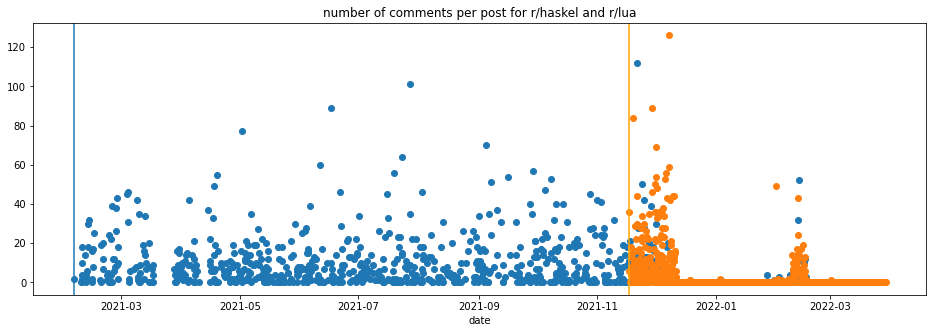

In [121]:
### look at posts and comments with time.
plot_feature_with_time(lisp_df, second_df = haskell_df, second_df_feature='num_comments', ylabel = '', figuresize = (16,5), title='');
plt.axvline(lisp_df['date'].min())
plt.axvline(haskell_df['date'].min(), color = 'orange')
plt.title("number of comments per post for r/haskel and r/lua");

It appears that the r/lisp data (blue) is much older than the r/haskell data (orange). The first date for each is marked with a vertical line. Since 1000 posts were gathered from each, the post rate must be higher for r/haskell.

We can see the effect of the AWS outage on the lua data as well.

In [119]:
#average lisp rate per day
post_rate(lisp_df, 'd')

2.3955482129556036

In [120]:
#average haskell rate per day
post_rate(haskell_df, 'd')

7.566156401208888

In [122]:
## drop columns and dummify using the same process as haskell
lisp_df_dum = full_data_process(lisp_df)
#save the data
lisp_df_dum.to_csv('./data_clean/lisp_dum.csv', index=None)

### r/lua

Perform identical steps for lua as well. This will not go into the model, but may in a future revision of this project.

In [124]:
#assign a label for plots and tables
this_subreddit = 'r/lua'

# look at dataframe size, column names, non-missing value count, data types.
lua_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1000 entries, 0.0 to 999.0
Data columns (total 83 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   all_awardings                  1000 non-null   object        
 1   allow_live_comments            1000 non-null   bool          
 2   author                         1000 non-null   object        
 3   author_flair_css_class         0 non-null      float64       
 4   author_flair_richtext          991 non-null    object        
 5   author_flair_text              0 non-null      float64       
 6   author_flair_type              991 non-null    object        
 7   author_fullname                991 non-null    object        
 8   author_is_blocked              479 non-null    object        
 9   author_patreon_flair           991 non-null    object        
 10  author_premium                 991 non-null    object        
 11  awarders    

In [125]:
# look at first few observations in the dataframe.
lisp_df.head()

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,...,author_flair_text_color,author_flair_template_id,removed_by_category,author_cakeday,gallery_data,is_gallery,media_metadata,poll_data,edited,date
0.0,[],False,npafitis,NaN,[],NaN,text,t2_2rlor0vv,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-28 14:11:55
1.0,[],False,a-concerned-mother,NaN,[],NaN,text,t2_ao35scl,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-27 15:27:38
2.0,[],False,dbotton,NaN,[],NaN,text,t2_ijymj,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-27 15:20:29
3.0,[],False,servingwater,NaN,[],NaN,text,t2_2743wkfe,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-27 13:20:05
4.0,[],False,dbotton,NaN,[],NaN,text,t2_ijymj,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-27 12:23:36


In [126]:
# look at summary statistics for numerical values.
lua_df.describe()

,author_flair_css_class,author_flair_text,created_utc,link_flair_background_color,num_comments,num_crossposts,pwls,retrieved_on,score,subreddit_subscribers,total_awards_received,upvote_ratio,wls,thumbnail_height,thumbnail_width,author_flair_background_color,edited
count,0.0,0.0,1.000000e+03,0.0,1000.000000,1000.0,1000.0,1.000000e+03,1000.000000,1000.000000,1000.0,1000.000000,1000.0,173.000000,173.000000,0.0,6.000000e+00
mean,NaN,NaN,1.626320e+09,NaN,4.910000,0.0,6.0,1.626326e+09,1.090000,12911.704000,0.0,0.976930,6.0,91.277457,137.976879,NaN,1.624512e+09
std,NaN,NaN,1.318258e+07,NaN,6.372795,0.0,0.0,1.317694e+07,0.877879,1056.751421,0.0,0.107274,0.0,33.339749,11.761167,NaN,1.034252e+07
min,NaN,NaN,1.605196e+09,NaN,0.000000,0.0,6.0,1.605196e+09,0.000000,11161.000000,0.0,0.140000,6.0,5.000000,70.000000,NaN,1.612511e+09
25%,NaN,NaN,1.613912e+09,NaN,0.000000,0.0,6.0,1.613912e+09,1.000000,11925.750000,0.0,1.000000,6.0,70.000000,140.000000,NaN,1.616786e+09
50%,NaN,NaN,1.625906e+09,NaN,3.000000,0.0,6.0,1.625906e+09,1.000000,12976.000000,0.0,1.000000,6.0,82.000000,140.000000,NaN,1.623821e+09
75%,NaN,NaN,1.638196e+09,NaN,7.000000,0.0,6.0,1.638196e+09,1.000000,13839.250000,0.0,1.000000,6.0,113.000000,140.000000,NaN,1.631088e+09
max,NaN,NaN,1.648465e+09,NaN,45.000000,0.0,6.0,1.648465e+09,15.000000,14625.000000,0.0,1.000000,6.0,140.000000,140.000000,NaN,1.638969e+09


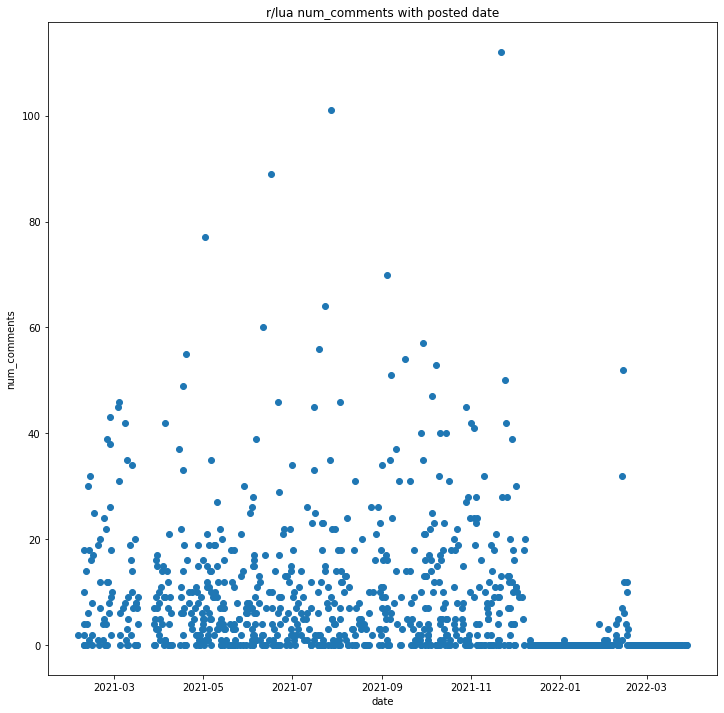

In [127]:
### look at posts and comments with time.
plot_feature_with_time(lisp_df, title=f'{this_subreddit} num_comments with posted date');

The outage is also seen here. This is an even less popular subreddit. I would prefer to use the other two as targets, as the same number of posts is a bit closer to concurrent.

In [128]:
#average posting rate per day
post_rate(lua_df)

1.9946065832074211

In [129]:
#average comment rate per day
post_rate(lua_df)

1.9946065832074211

In [ ]:
#save the lua data.
lua_df_dum = full_data_process(lua_df)

lua_df_dum.to_csv('./data_clean/lua_dum.csv', index=None)

---

From here, the data will be used by Notebook 3